In [1]:
from skimage import data, segmentation, color
from skimage.future import graph
from matplotlib import pyplot as plt
import numpy as np
import cv2
from sklearn.decomposition import PCA

In [2]:
def img2lab(img_path):
    bgr_img = cv2.imread(img_path)
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return cv2.cvtColor(rgb_img, cv2.COLOR_BGR2LAB)

In [3]:
def pad_img(img, kernel_size):
    '''input: img: a NumPy array, get from function img2lab
              kernel_size: an int number, maybe 3*3 or 5*5 or 7*7 etc. 7*7 in paper
       output:img: a image after padding
    '''
    size = (kernel_size - 1) / 2
    img_pad = cv2.copyMakeBorder(img, size, size, size, size, cv2.BORDER_REPLICATE)
    return img_pad

def pixel_patch_vectorize(img_pad, kernel_size, stride):
    H, W, C = img_pad.shape
    s0, s1, s2 = img_pad.strides
    nH = H - kernel_size + 1
    nW = W - kernel_size + 1
    # In there kernel size is a square in all 3 channels
    # Actually, the size of kernel is  kernel_size*kernel_size*3
    nC = C - 3 + 1
    
    shp = kernel_size, kernel_size, C, nH, nW, nC
    strd = s0, s1, s2, s0, s1, s2
    out_view = np.lib.stride_tricks.as_strided(img_pad, shape=shp, strides=strd)
    img_patch_full = out_view.reshape(kernel_size*kernel_size*C, nH, nW).transpose(1,2,0)
    H_idx = np.array(range(0, nH, stride)).reshape(-1,1)
    W_idx = np.array(range(0, nW, stride)).reshape(1,-1)
    return img_patch_full[H_idx, W_idx]

In [4]:
def texture_feature(img, W, D):
    '''
        Input: 
            img: a image;
            W: a list of window sizes, in paper: W = [1,3,5,7];
            D: D principal components, in paper: D = 8;
        Output:
            txt_feats: a dictionary contains texture features 
                        after PCA for each window size in W.
    '''
    txt_feats = {}
    H, WW, C = img.shape
    for w in W:
        img_pad = pad_img(img, w)
        img_patch = pixel_patch_vectorize(img_pad, w, stride = 1)
        X = img_patch.reshape(-1, w*w*3)
        if X.shape[1] > D:
            # Reduce dimensionality by PCA
            pca = PCA(n_components=D)
            X_hat = pca.fit_transform(X)
            txt_feats[str(w)] = X_hat.reshape(H, WW, -1)
        else:
            txt_feats[str(w)] = X.reshape(H, WW, -1)
    return txt_feats

In [5]:
def texture_encoding(i, sp_label, D, txt_feats, w, eps):
    '''
        Input:
            i: the ith region in superpixel image;
            sp_label: the region labels;
            D: D principal components, in paper: D = 8;
            txt_feats: ...
            w: window size, 1, 3, 5, 7
            eps: epslion
        Output:
            L_texture: a scala, means the number of bits we need to encode 
                        the texture feature for this region;
    '''
    # All idices of a region in superpixel image;
    R = np.argwhere(sp_label == i)
    # number of pixels in region R
    N = R.shape[0]
    # get txt_feat in w
    X_hat = txt_feats[str(w)]
    # The shape of X_har_r: (R.shape[0], <=D)
    X_hat_r = X_hat[R[:,0], R[:,1]].T
    # calculate mean and convariance
    r_mean = np.mean(X_hat_r, axis=1)
    r_convar = np.cov(X_hat_r)
    L_texture = (D + N/w**2)*np.log(np.linalg.det(np.eye(D, dtype=np.float32)+D*1./eps**2*r_convar))
    L_texture += D * np.log(1 + np.linalg.norm(r_mean)/eps**2)
    return L_texture / np.log(4)

In [6]:
def superpixel(img, n_sp=200):
    labels1  = segmentation.slic(img, compactness=10, n_segments=n_sp)
#     rag = graph.rag_mean_color(img, labels1, mode = 'similarity')
#     new_labels = graph.cut_normalized(labels1, rag, num_cuts=n_sp)
    return labels1

https://www.kaggle.com/mburger/freeman-chain-code-second-attempt

In [7]:
def boundary_encoding(i, labels1):
    '''
        Input:
            i: the ith region in superpixel image;
            sp_label: the region labels;
        Output:
            B: a scala, means the number of bits we need to encode 
                        the boundary information for this region;
    '''
#     print 'i'+str(i)
    H, W = labels1.shape
    start_point = np.argwhere(labels1 == i)[0]
#     print 'start point'+str(start_point)
    directions = [3, 2, 1,
                  4,    0,
                  5, 6, 7]
    dir2idx = dict(zip(directions, range(len(directions))))

    change_j =   [-1,  0,  1, # x or columns
                  -1,      1,
                  -1,  0,  1]

    change_i =   [-1, -1, -1, # y or rows
                   0,      0,
                   1,  1,  1]
    codebooks = np.hstack((np.array(change_i).reshape(-1,1),
                           np.array(change_j).reshape(-1,1)))
    
    border = []
    chain = []
    curr_point = start_point
    for direction in directions:
        idx = dir2idx[direction]
    #     print idx
    #     print codebooks[idx]
        new_point = start_point + codebooks[idx]
    #     print new_point
        if new_point[0]<H and new_point[1]<W and labels1[new_point[0], new_point[1]] == i: # if is ROI
            border.append(new_point)
#             print new_point
            chain.append(direction)
            curr_point = new_point
            break

    count = 0
    while list(curr_point) != list(start_point):
        #figure direction to start search
        b_direction = (direction + 5) % 8 
        dirs_1 = range(b_direction, 8)
        dirs_2 = range(0, b_direction)
        dirs = []
        dirs.extend(dirs_1)
        dirs.extend(dirs_2)
        for direction in dirs:
            idx = dir2idx[direction]
            new_point = curr_point + codebooks[idx]
            if abs(new_point[0])<H and abs(new_point[1])<W and labels1[new_point[0], new_point[1]] == i: # if is ROI
                border.append(new_point)
                chain.append(direction)
                curr_point = new_point
                break
        if count == 1000: break
        count += 1
#     print count
#     print chain
    chain = np.array(chain)
    diff_chain = (chain[1:] - chain[:-1])%8
    BSD = np.array([0.585, 0.190, 0.020, 1e-4, 0.002, 0.003, 0.031, 0.169])
#     print diff_chain
    diff_chain = np.append(diff_chain, 7)
#     print diff_chain
    times = np.bincount(diff_chain)
#     print times
    times[7] -= 1
#     print times
    B = -np.sum(times*np.log(BSD)/np.log(2))
    return B

In [8]:
def union(i , j, sp_label):
    i = min(i, j)
    temp_sp_label = sp_label.copy()
    temp_sp_label[temp_sp_label==max(i,j)] = i
    return temp_sp_label, i

In [9]:
def delta_L(i ,j ,sp_label, D, txt_feats, w, eps):
    '''
        Input:
            i,j: the ith region in superpixel image;
            sp_label: the region labels;
        Output:
            delta_i_j: the decrease of L, if union Ri and Rj
    '''
    # mark
    sp_label_union, k = union(i, j, sp_label)

    L_i = texture_encoding(i, sp_label, D, txt_feats, w, eps)
    L_j = texture_encoding(j, sp_label, D, txt_feats, w, eps)
    L_ij = texture_encoding(k, sp_label_union, D, txt_feats, w, eps)
#     print 'i'+str(i)
    B_i = boundary_encoding(i, sp_label)
#     print 'j'+str(j)
    B_j = boundary_encoding(j, sp_label)
    B_ij = boundary_encoding(k, sp_label_union)
    
    delta_i_j = L_i + L_j - L_ij + 0.5*(B_i + B_j - B_ij)
    return delta_i_j

In [10]:
def Isdegenerate(sp_label, W):
    N = sp_label.max() + 1
    Isdeg_W = {}
    for w in W:
        Isdeg_w = np.zeros(N)
        img_pad = pad_img(sp_label, w)
        img_pad = img_pad[:, :, np.newaxis]
        img_pad = np.tile(img_pad, (1,1,3))
        img_patch = pixel_patch_vectorize(img_pad, w, stride = 1)
        img_patch_mean = np.mean(img_patch, axis = 2)
        in_region = sp_label - img_patch_mean
        for i in range(N):
            idx = np.argwhere(sp_label == i)
            idx_zero = np.argwhere(in_region[idx[:,0], idx[:,1]]==0)
            if idx_zero.shape[0] == 0:
                Isdeg_w[i] = 1
        Isdeg_W[str(w)] = Isdeg_w
    return Isdeg_W

In [11]:
def get_seg_label(PATH, eps):
#     PATH = './coffe.png'
    img = img2lab(PATH)
    img = cv2.resize(img, (250, int(img.shape[0]*1./img.shape[1]*250)))
    
    W = [7, 5, 3, 1]
    D = 8
#     eps = 25
    
    # get texture features for each window size
    txt_feats = texture_feature(img, W, D)
    # get superpixels R
    sp_label = superpixel(img, n_sp=200)
    #
#     i , j= 38,0
#     delta_L(i ,j , sp_label, D, txt_feats, 7, eps)
    #
    # get degenerate region map
    Isdeg_W = Isdegenerate(sp_label, W)
    # number of regions
    N = sp_label.max() + 1
    # construct RAG, where edge is 1
    edge_map = np.ones(sp_label.shape)
    G = graph.rag_boundary(sp_label, edge_map)
    
    w_m = W[0]
    w = w_m
    update_sp_label = sp_label.copy()
    # save delta_L(i,j) for each w

    dlt_l_m = np.zeros((N, N), np.float32)
    Isdeg_w = Isdeg_W[str(w)]
    for i in range(N-1):
        if G.has_node(i) and Isdeg_w[i] == 0:
            for j in range(i+1, N):
                if G.has_edge(i, j) and Isdeg_w[j]==0:
#                         print 'wm: '+str(w)+'i: '+str(i)+'j: '+str(j)
                    dlt_l_m[i,j] = delta_L(i ,j ,sp_label, D, txt_feats, w, eps)
    iters = 0
    while iters < 1000:
        Isdeg_w = Isdeg_W[str(w)]
        max_dlt_l = 0
        if w == w_m:
            for i in range(N-1):
                if G.has_node(i) and Isdeg_w[i] == 0:
                    for j in range(i+1, N):
                        if G.has_edge(i, j) and Isdeg_w[j]==0:
#                             print 'wm: '+str(w)+'i: '+str(i)+'j: '+str(j)
#                             dlt_l = delta_L(i ,j ,update_sp_label, D, txt_feats, w, eps)
                            if dlt_l_m[i,j] > max_dlt_l:
                                max_dlt_l = dlt_l_m[i,j]
                                i_save, j_save = i, j
        else:
            Isdeg_w2 = Isdeg_W[str(w+2)]
            for i in range(N-1):
                if G.has_node(i) and Isdeg_w[i] == 0:
                    for j in range(i+1, N):
                        if G.has_edge(i, j) and Isdeg_w[j]==0:
                            if Isdeg_w2[i] == 1 or Isdeg_w2[j] == 1:
#                                 print 'w: '+str(w)+'i: '+str(i)+'j: '+str(j)
                                dlt_l = delta_L(i ,j ,update_sp_label, D, txt_feats, w, eps)
                                if dlt_l > max_dlt_l:
                                    max_dlt_l = dlt_l
                                    i_save, j_save = i, j
        
        if max_dlt_l>0:
            # Union i and j to i, in_place means change j to i
            G.merge_nodes(j_save, i_save, in_place=True)
            update_sp_label, i_save = union(i_save , j_save, update_sp_label)
            w = w_m
#             print 'Union {0} and {1}'.format(i_save, j_save)
            # update dlt_l_m
            for j_ in range(i_save+1, N):
                if G.has_edge(i_save, j_) and Isdeg_w[j_]==0:
                    dlt_l_m[i_save, j_] = delta_L(i_save, j_ ,update_sp_label, D, txt_feats, w, eps)
        elif w != 1:
            w -= 2
        flag = 0
        for i in range(N):
            if G.has_node(i) and Isdeg_W[str(w_m)][i] == 0:
                for j in range(i+1, N):
                    if G.has_edge(i, j) and Isdeg_W[str(w_m)][j]==0:
                        dlt_l = delta_L(i, j ,update_sp_label, D, txt_feats, w_m, eps)
                        if dlt_l > 0:
                            flag = 1
        if flag == 0:
            break
        iters += 1
    return update_sp_label, img

When epslion is 25
The original image:


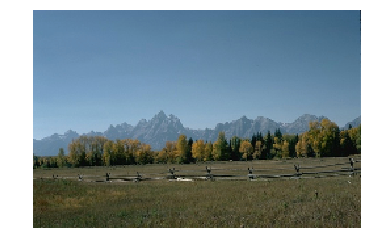

The segmentation image


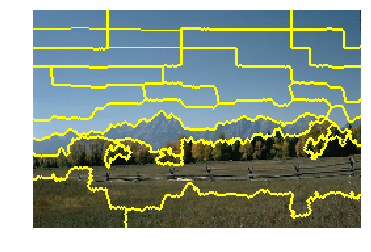

The original image:


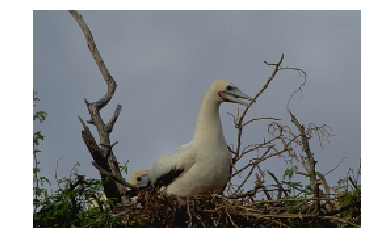

The segmentation image


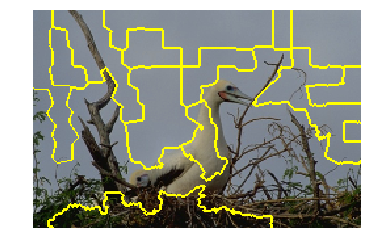

The original image:


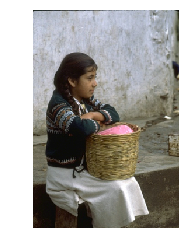

The segmentation image


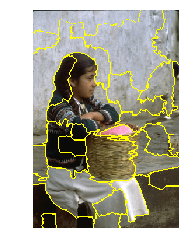

When epslion is 300
The original image:


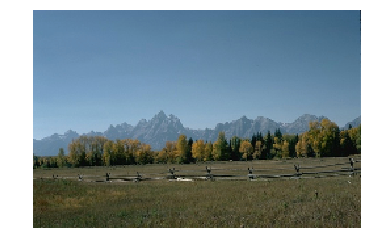

The segmentation image


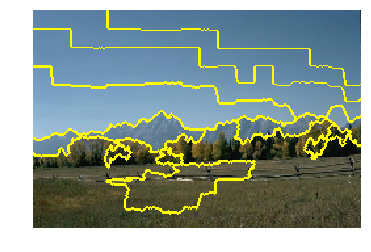

The original image:


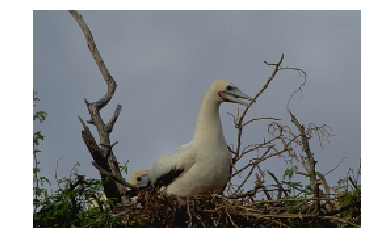

The segmentation image


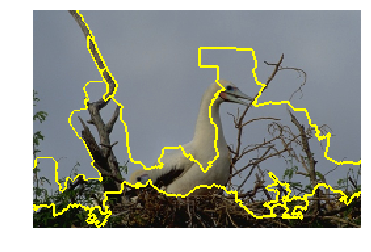

The original image:


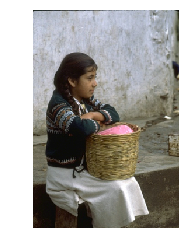

The segmentation image


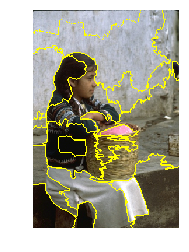

When epslion is 600
The original image:


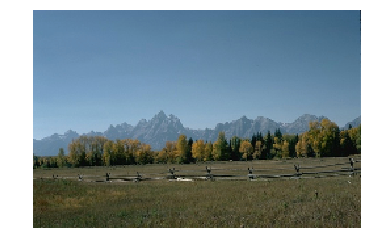

The segmentation image


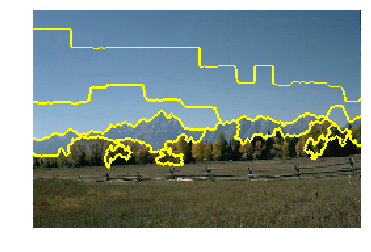

The original image:


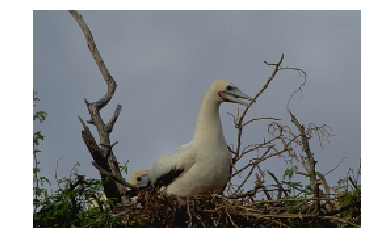

The segmentation image


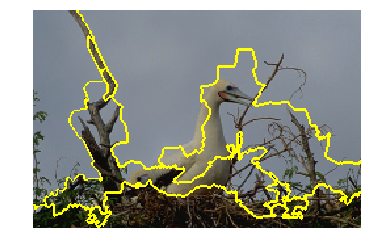

The original image:


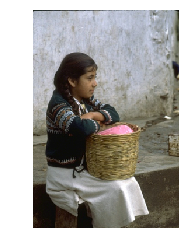

The segmentation image


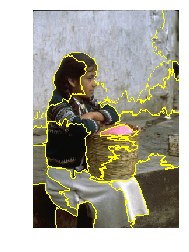

When epslion is 1000
The original image:


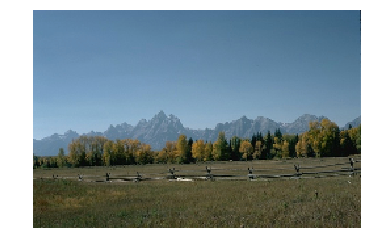

The segmentation image


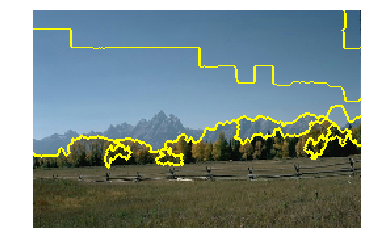

The original image:


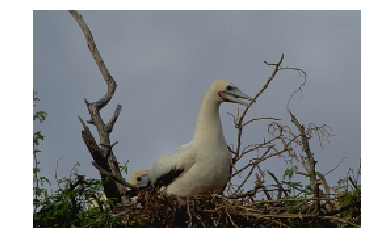

The segmentation image


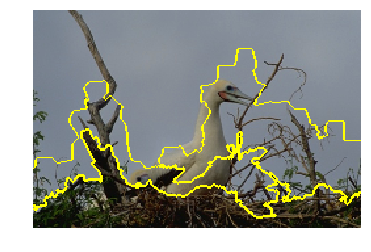

The original image:


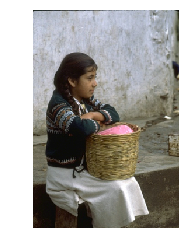

The segmentation image


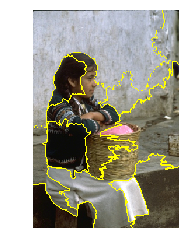

In [12]:
PATH = './BSDS300/images/train/'
img_set = ['2092', '8049', '23025']
img_label = {}
img_orig_lab = {}
EPS = [25, 300, 600, 1000]
for eps in EPS:
    print 'When epslion is {0}'.format(eps)
    for img_id in img_set:
        img_path = PATH + img_id + '.jpg'
        label, img = get_seg_label(img_path, eps)
        img_label[img_id] = label
        img_orig_lab[img_id] = img
        img = cv2.cvtColor(img, cv2.COLOR_Lab2BGR)
        print 'The original image:'
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        print 'The segmentation image'
        seg_img = segmentation.mark_boundaries(img, label)
        plt.imshow(seg_img)
        plt.axis('off')
        plt.show()

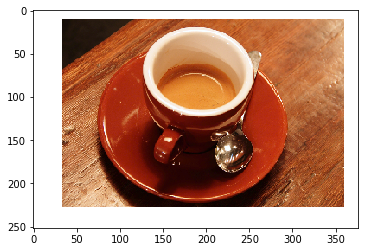

(167, 250, 3)


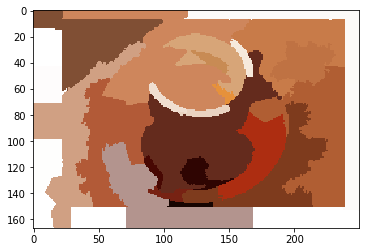

In [279]:
PATH = './coffe.png'
img = img2lab(PATH)

img = cv2.cvtColor(img, cv2.COLOR_Lab2BGR)

plt.imshow(img)
plt.show()
img = cv2.resize(img, (250, int(img.shape[0]*1./img.shape[1]*250)))
# b,g,r = cv2.split(img)
# rgb_img = cv2.merge([r,g,b])
# plt.imshow(rgb_img)
# plt.axis('off')
plt.show()
out2 = color.label2rgb(label, img, kind='avg')
print out2.shape
plt.imshow(out2)
# plt.axis('off')
plt.show()

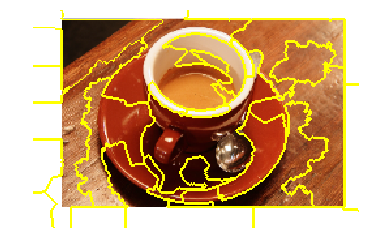

In [257]:
seg_img = segmentation.mark_boundaries(rgb_img, label)
plt.imshow(seg_img)
plt.axis('off')
plt.show()